In [ ]:
# reference: https://www.kaggle.com/kernels/scriptcontent/18471575/download

In [76]:
import zipfile
import pandas as pd
import numpy as np,gc
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, train_test_split,GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from time import time
import datetime

import warnings
warnings.filterwarnings('ignore')

In [2]:
with zipfile.ZipFile("ieee-fraud-detection.zip","r") as z:
    f=z.open('train_identity.csv')
    train_identity = pd.read_csv(f)
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [3]:
with zipfile.ZipFile("ieee-fraud-detection.zip","r") as z:
    f=z.open('train_transaction.csv')
    train_transaction = pd.read_csv(f)
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
with zipfile.ZipFile("ieee-fraud-detection.zip","r") as z:
    f1=z.open('test_transaction.csv')
    test_transaction = pd.read_csv(f1)
    f2=z.open('test_identity.csv')
    test_identity = pd.read_csv(f2)

In [6]:
all_train=pd.merge(train_transaction,train_identity,how="left",on="TransactionID")
print(all_train.shape)
all_train["tag"]="train"
print(all_train.shape)

(590540, 434)
(590540, 435)


In [7]:
print(test_transaction.shape)
print(test_identity.shape)
all_test=pd.merge(test_transaction,test_identity,how="left",on="TransactionID")
print(all_test.shape)
all_test["tag"]="test"
print(all_test.shape)

(506691, 393)
(141907, 41)
(506691, 433)
(506691, 434)


In [8]:
all_df=pd.concat([all_train.drop(["isFraud"],axis=1),all_test],axis=0)
print(all_df.shape)

(1097231, 434)


In [9]:
y_train=train_transaction[["isFraud","TransactionID"]]#keep TransactionID here in case we sort
y_train.shape

(590540, 2)

In [10]:
# for a credit card(how do we define a unique credit card), if it has multiple txns and isFraud, how does it look like?
cards=['card1','card2', 'card3', 'card4', 'card5', 'card6']
train_transaction[cards].head(5)

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


In [11]:
###
# Categorical Features:
# ProductCD
# card1 - card6
# addr1, addr2
# Pemaildomain Remaildomain
# M1 - M9
#
cs=["C1","C2"]
train_transaction[cs].head(5)

,C1,C2
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,2.0,5.0
4,1.0,1.0


In [12]:
ds=["D1","D2","D3","D4","D5","D6","D7","D8","D9","D10","D11","D12","D13","D14","D15"]
train_transaction[ds].head(5)

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
ms=["M1","M2","M3","M4","M5","M6","M7","M8","M9"]
train_transaction[ms].head(5)

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,T,T,T,M0,F,F,F,F,F
3,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
ads=["addr1", "addr2"]
train_transaction[ads].head(5)

,addr1,addr2
0,315.0,87.0
1,325.0,87.0
2,330.0,87.0
3,476.0,87.0
4,420.0,87.0


In [15]:
ems=["P_emaildomain", "R_emaildomain"]
train_transaction[ems].head(5)

,P_emaildomain,R_emaildomain
0,NaN,NaN
1,gmail.com,NaN
2,outlook.com,NaN
3,yahoo.com,NaN
4,gmail.com,NaN


In [16]:
cols_t = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']
cols_v=["V"+str(i) for i in range(1,340)]
types={}
for v in cols_v: types[v]="float32"

In [18]:
train=train_transaction[cols_t+['isFraud']+cols_v]
train.shape

(590540, 394)

In [20]:
nans_df = train.isna()
nans_groups={}
for col in train.columns:
    nan_num = nans_df[col].sum()
    try:
        nans_groups[nan_num].append(col)
    except:
        nans_groups[nan_num]=[col]
del nans_df; x=gc.collect()

In [46]:
train_transaction[ms].head(5)

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,T,T,T,M0,F,F,F,F,F
3,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


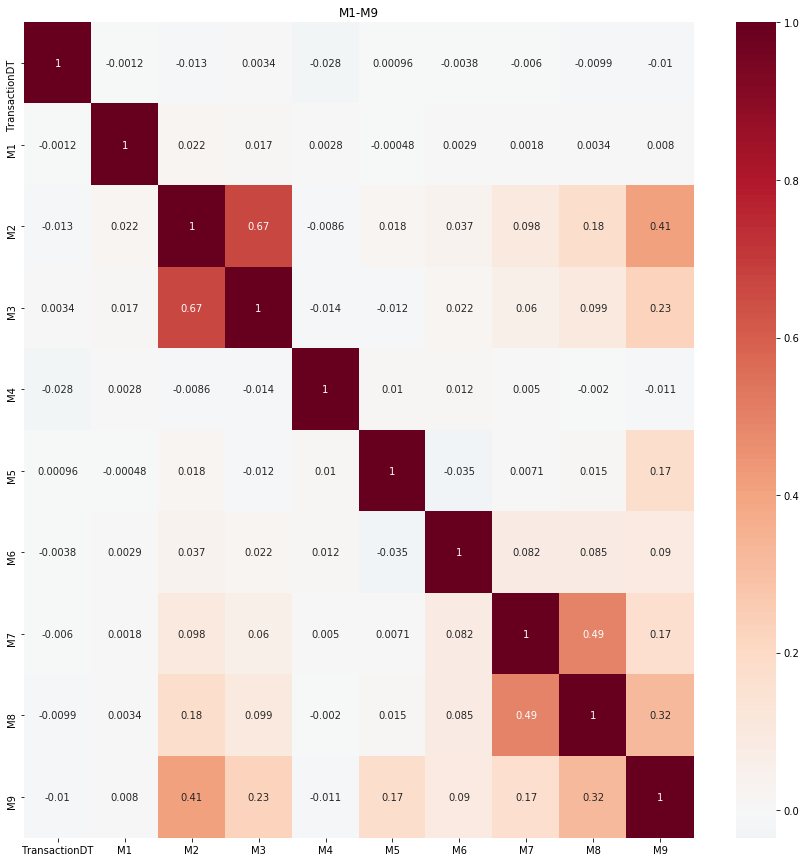

In [48]:
Ms = ['M'+str(x) for x in range(1,10)]
mp = {'F':0,'T':1,'M0':0,'M1':1,'M2':2}
for c in Ms: train[c] = train[c].map(mp)
cols = ['TransactionDT'] + Ms
plt.figure(figsize=(15,15))
sns.heatmap(train[cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
plt.title('M1-M9')
plt.show()

In [49]:
# Categorical Features:
# ProductCD
# card1 - card6
# addr1, addr2
# Pemaildomain Remaildomain
# M1 - M9
# TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
# TransactionAMT: transaction payment amount in USD
# ProductCD: product code, the product for each transaction
# card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
# addr: address
# dist: distance
# P_ and (R__) emaildomain: purchaser and recipient email domain
# C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
# D1-D15: timedelta, such as days between previous transaction, etc.
# M1-M9: match, such as names on card and address, etc.
# Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

In [87]:
cols_use=['V1', 'V3', 'V4', 'V6', 'V8', 'V11',
 'V13', 'V14', 'V17', 'V20', 'V23', 'V26', 'V27', 'V30',
 'V36', 'V37', 'V40', 'V41', 'V44', 'V47', 'V48', 'V54',
 'V56', 'V59', 'V62', 'V65', 'V67', 'V68', 'V70', 'V76', 'V78', 'V80', 'V82',
 'V86', 'V88', 'V89', 'V91', 'V96', 'V98', 'V99', 'V104', 'V107', 'V108',
 'V111', 'V115', 'V117', 'V120', 'V121', 'V123', 'V124', 'V127',
 'V129', 'V130', 'V136', 'V138', 'V139', 'V142', 'V147', 'V156',
 'V162', 'V165', 'V160', 'V166', 'V178', 'V176', 'V173', 'V182',
 'V187', 'V203', 'V205', 'V207', 'V215', 'V169', 'V171', 'V175',
 'V180', 'V185', 'V188', 'V198', 'V210', 'V209', 'V218', 'V223',
 'V224', 'V226', 'V228', 'V229', 'V235', 'V240', 'V258', 'V257',
 'V253', 'V252', 'V260', 'V261', 'V264', 'V266', 'V267', 'V274',
 'V277', 'V220', 'V221', 'V234', 'V238', 'V250', 'V271', 'V294',
 'V284', 'V285', 'V286', 'V291', 'V297', 'V303', 'V305', 'V307',
 'V309', 'V310', 'V320', 'V281', 'V283', 'V289',
 'V296', 'V301', 'V314', 'V332', 'V325', 'V335', 'V338', 
 'C1', 'C3', 'C5', 'C13', 'D1', 'D6', 'D3', 'D5', 'D8', 'D9', 'D10', 'D11', 'D13', 'D14', 'D15']

['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V96',
 'V98',
 'V99',
 'V104',
 'V107',
 'V108',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V138',
 'V139',
 'V142',
 'V147',
 'V156',
 'V162',
 'V165',
 'V160',
 'V166',
 'V178',
 'V176',
 'V173',
 'V182',
 'V187',
 'V203',
 'V205',
 'V207',
 'V215',
 'V169',
 'V171',
 'V175',
 'V180',
 'V185',
 'V188',
 'V198',
 'V210',
 'V209',
 'V218',
 'V223',
 'V224',
 'V226',
 'V228',
 'V229',
 'V235',
 'V240',
 'V258',
 'V257',
 'V253',
 'V252',
 'V260',
 'V261',
 'V264',
 'V266',
 'V267',
 'V274',
 'V277',
 'V220',
 'V221',
 'V234',
 'V238',
 'V250',
 'V271',
 'V294',
 'V284',
 'V285',
 'V286',
 'V291',
 'V297',
 'V303',
 'V305',
 'V307',
 'V309',
 

In [50]:
print(len(cols_use))
id_str=['id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30','id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
ids = ['id'+"_0"+str(x) for x in range(1,10)]+['id'+"_"+str(x) for x in range(10,39)]
for i in id_str:
    ids.remove(i)
cols_use=cols_use+['card1', 'card2', 'card3', 'card5']+ids


143


In [51]:
# cols_use is numerical
str_type = ['ProductCD', 'card4', 'card6', 'addr1', 'addr2', 'dist1', 'dist2','P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

In [52]:
# we want to use: cols_use+str_type+['TransactionID', 'TransactionDT', 'TransactionAmt']
# X_train=all_train[cols_use+str_type+['TransactionID', 'TransactionDT', 'TransactionAmt']]
# X_train.shape
all_df2=all_df[cols_use+str_type+['TransactionID', 'TransactionDT', 'TransactionAmt']]
all_df2.shape

(1097231, 208)

In [54]:
temp=all_df2['R_emaildomain'].value_counts().to_dict()
all_df2['R_dmail_count']=all_df2['R_emaildomain'].map(temp)

temp=all_df2['P_emaildomain'].value_counts().to_dict()
all_df2['P_dmail_count']=all_df2['P_emaildomain'].map(temp)

temp=all_df2["DeviceInfo"].value_counts().to_dict()
all_df2['DeviceInfo_count']=all_df2['DeviceInfo'].map(temp)

temp=all_df2["id_30"].value_counts().to_dict()
all_df2['id_30_count']=all_df2['id_30'].map(temp)

temp=all_df2["id_31"].value_counts().to_dict()
all_df2['id_31_count']=all_df2['id_31'].map(temp)

In [55]:
domain_list=["gmail","hotmail","anonymous","yahoo","aol.com","outlook","comcast","icloud"]
def emil_do(s,domain_list):
    s=str(s)
    for l in domain_list:
        if l in s:
            return l

In [56]:
all_df2["P_dmail"]=all_df2["P_emaildomain"].map(lambda x: emil_do(x,domain_list))
all_df2["R_dmail"]=all_df2["R_emaildomain"].map(lambda x: emil_do(x,domain_list))

In [57]:
all_df2["P_dmail"].value_counts()

gmail        436796
yahoo        186568
hotmail       87414
anonymous     71062
aol.com       52337
comcast       14474
icloud        12316
outlook       10797
Name: P_dmail, dtype: int64

In [58]:
id_str=['id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30','id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
for id in id_str:
    print(all_df2[id].value_counts())

NotFound    243920
Found        42220
Name: id_12, dtype: int64
Found      135690
New        119397
Unknown     22875
Name: id_15, dtype: int64
Found       132805
NotFound    122282
Name: id_16, dtype: int64
IP_PROXY:TRANSPARENT    7203
IP_PROXY:ANONYMOUS      2010
IP_PROXY:HIDDEN         1018
Name: id_23, dtype: int64
Found       10214
NotFound       17
Name: id_27, dtype: int64
Found    151813
New      125943
Name: id_28, dtype: int64
Found       149264
NotFound    128492
Name: id_29, dtype: int64
Windows 10          42170
Windows 7           23478
iOS 12.1.0           6349
Mac OS X 10_12_6     3884
iOS 11.2.1           3824
Mac OS X 10_11_6     3802
iOS 11.1.2           3776
Android 7.0          3573
iOS 11.4.1           3539
Windows 8.1          3308
Mac OS X 10_13_6     3254
Android 8.0.0        2798
iOS 11.3.0           2662
Mac OS X 10_10_5     2575
Linux                2488
iOS 10.3.3           2043
Android              1848
iOS 11.2.6           1834
iOS 12.0.1           1691
i

In [59]:
def device_trans(input_str):
    input_str=str(input_str).lower()
    if input_str=="nan":
        return "NAN"
    elif input_str[:3]=="ios":
        return "IOS"
    elif input_str[:7]=="windows":
        return "Windows" 
    elif input_str[:3]=="sm-" or input_str[:7]=="samsung":
        return "SM" 
    elif input_str[:7]=="trident":
        return "Trident"  
    elif input_str[:2]=="lg":
        return "LG" 
    elif input_str[:3]=="rv:":
        return "rv" 
    elif input_str[:4]=="moto":
        return "Moto"
    elif input_str[:5]=="macos":
        return "MacOS" 
    elif "huawei" in input_str:
        return "HUAWEI"
    else:
        return "else"
all_df2["DeviceInfo_1"]=all_df2["DeviceInfo"].map(device_trans)

In [60]:
def id_30_map(input_str):
    input_str=str(input_str).lower()
    if input_str=="nan":
        return "NAN"    
    elif input_str[:7]=="windows":
        return "windows"
    elif input_str[:3]=="ios":
        return "ios"
    elif input_str[:3]=="mac":
        return "mac"
    elif input_str[:7]=="android":
        return "andriod"
    elif input_str[:5]=="linux":
        return "linux"
    else:
        return "else"
    
all_df2["id_30_1"]=all_df2["id_30"].map(id_30_map)
all_df2["id_30_1"].value_counts()

NAN        949007
windows     69777
ios         38502
mac         25634
andriod     11783
linux        2488
else           40
Name: id_30_1, dtype: int64

In [61]:
 def id_31_map(input_str):
    input_str=str(input_str).lower()
    if input_str=="nan":
        return "NAN"  
    elif input_str[:7]=="firefox":
        return "firefox"
    elif input_str[:7]=="android":
        return "android"
    elif input_str[:7]=="samsung":
        return "samsung"
    elif input_str[:6]=="chrome":
        return "chrome"
    elif input_str[:6]=="google":
        return "google"
    elif input_str[:2]=="ie":
        return "ie"
    elif input_str[:6]=="mobile":
        return "mobile"
    elif input_str[:5]=="opera":
        return "opera"
    elif input_str[:6]=="safari":
        return "safari"
    elif input_str[:4]=="edge":
        return "edge"
    else:
        return "else"
    
all_df2["id_31_1"]=all_df2["id_31"].map(id_31_map)
all_df2["id_31_1"].value_counts()

NAN        820324
chrome     155502
mobile      53259
safari      16625
ie          15603
firefox     14388
edge        11985
samsung      4787
google       2146
android      1051
opera         843
else          718
Name: id_31_1, dtype: int64

In [62]:
id_str2=['id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
 # exclude 'id_30','id_31'
for id in id_str2:
    all_df2[id]=all_df2[id].factorize(sort=True)[0]
all_df2["DeviceType"]=all_df2["DeviceType"].factorize(sort=True)[0]
all_df2["DeviceInfo_2"]=all_df2["DeviceInfo_1"].factorize(sort=True)[0]
all_df2["id_30_2"]=all_df2["id_30_1"].factorize(sort=True)[0]
all_df2["id_31_2"]=all_df2["id_31_1"].factorize(sort=True)[0]

In [63]:
all_df2["P_dmail_num"]=all_df2["P_dmail"].factorize(sort=True)[0]
all_df2["R_dmail_num"]=all_df2["R_dmail"].factorize(sort=True)[0]         
all_df2["ProductCD"]=all_df2["ProductCD"].factorize(sort=True)[0]
all_df2["card4"]=all_df2["card4"].factorize(sort=True)[0] 
all_df2["card6"]=all_df2["card6"].factorize(sort=True)[0] 
    
Ms = ['M'+str(x) for x in range(1,10)]
mp_m = {'F':0,'T':1,'M0':0,'M1':1,'M2':2}
for c in Ms: all_df2[c] = all_df2[c].map(mp_m)


In [64]:
all_df2.head(5)

,V1,V3,V4,V6,V8,V11,V13,V14,V17,V20,...,P_dmail,R_dmail,DeviceInfo_1,id_30_1,id_31_1,DeviceInfo_2,id_30_2,id_31_2,P_dmail_num,R_dmail_num
0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,None,None,NAN,NAN,NAN,5,0,0,-1,-1
1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,...,gmail,None,NAN,NAN,NAN,5,0,0,3,-1
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,outlook,None,NAN,NAN,NAN,5,0,0,6,-1
3,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,...,yahoo,None,NAN,NAN,NAN,5,0,0,7,-1
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,gmail,None,SM,andriod,samsung,6,1,11,3,-1


In [65]:
all_df2["addr"]=all_df2["addr1"].astype(str)+"_"+all_df2["addr2"].astype(str)
all_df2.head(5)

,V1,V3,V4,V6,V8,V11,V13,V14,V17,V20,...,R_dmail,DeviceInfo_1,id_30_1,id_31_1,DeviceInfo_2,id_30_2,id_31_2,P_dmail_num,R_dmail_num,addr
0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,None,NAN,NAN,NAN,5,0,0,-1,-1,315.0_87.0
1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,...,None,NAN,NAN,NAN,5,0,0,3,-1,325.0_87.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,None,NAN,NAN,NAN,5,0,0,6,-1,330.0_87.0
3,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,...,None,NAN,NAN,NAN,5,0,0,7,-1,476.0_87.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,SM,andriod,samsung,6,1,11,3,-1,420.0_87.0


In [66]:
cols_D=['D1',
 'D6',
 'D3',
 'D5',
 'D8',
 'D9',
 'D10',
 'D11',
 'D13',
 'D14',
 'D15']
for col in cols_D: 
    new_col = 'uid_td_'+str(col)
    
    all_df2[new_col] = all_df2['TransactionDT'] / (24*60*60)
    all_df2[new_col] = np.floor(all_df2[new_col] - all_df2[col]) + 1000
all_df2['DT_day'] = np.floor(all_df2['TransactionDT']/(24*60*60)) + 1000
all_df2["count0"]=all_df2.groupby(["addr","card1","uid_td_D1"])["TransactionID"].transform('count')
all_df2["count1"]=all_df2.groupby(["addr1","card1","uid_td_D1"])["TransactionID"].transform('count')
all_df2["count2"]=all_df2.groupby(["addr1","card1","P_emaildomain","uid_td_D1"])["TransactionID"].transform('count')
all_df2["count3"]=all_df2.groupby(["addr1","card1","P_emaildomain","uid_td_D1"])["TransactionAmt"].transform('mean')
all_df2["count4"]=all_df2.groupby(["addr1","card1","P_emaildomain","uid_td_D1"])["TransactionAmt"].transform('sum')

In [67]:
all_df2=all_df2.drop(['TransactionDT',"P_emaildomain","R_emaildomain","P_dmail","R_dmail","addr1","addr2","addr","DeviceInfo_1","DeviceInfo","id_30_1","id_30","id_31_1","id_31"]+cols_D,axis=1)
all_df2.head(5)

,V1,V3,V4,V6,V8,V11,V13,V14,V17,V20,...,uid_td_D11,uid_td_D13,uid_td_D14,uid_td_D15,DT_day,count0,count1,count2,count3,count4
0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,988.0,NaN,NaN,1001.0,1001.0,1.0,1.0,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,...,NaN,NaN,NaN,1001.0,1001.0,1.0,1.0,1.0,29.000000,29.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,686.0,NaN,NaN,686.0,1001.0,4.0,4.0,4.0,73.500000,294.0
3,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,...,NaN,NaN,NaN,890.0,1001.0,84.0,84.0,84.0,66.392857,5577.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1001.0,1.0,1.0,1.0,50.000000,50.0


In [68]:
cols=all_df2.columns
X_train=all_df2.iloc[:590540,:]
X_test=all_df2.iloc[590540:,:]

In [69]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

In [72]:
y_train=train_transaction[["isFraud","TransactionID"]]#keep TransactionID here in case we sort
y=y_train["isFraud"]

In [77]:
folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X_train, y)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.998913	valid_1's auc: 0.901106
Early stopping, best iteration is:
[1255]	training's auc: 0.999951	valid_1's auc: 0.902935
Fold 1 finished in 0:01:53.804282
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.998313	valid_1's auc: 0.928515
[2000]	training's auc: 1	valid_1's auc: 0.931006
Early stopping, best iteration is:
[1569]	training's auc: 0.999994	valid_1's auc: 0.931084
Fold 2 finished in 0:04:14.887914
Training on fold 3
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.996345	valid_1's auc: 0.919289
Early stopping, best iteration is:
[1476]	training's auc: 0.999829	valid_1's auc: 0.921482
Fold 3 finished in 0:05:57.156569
Training on fold 4
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.992858	valid_1's auc: 0.937404
[2000]	training's auc: 0

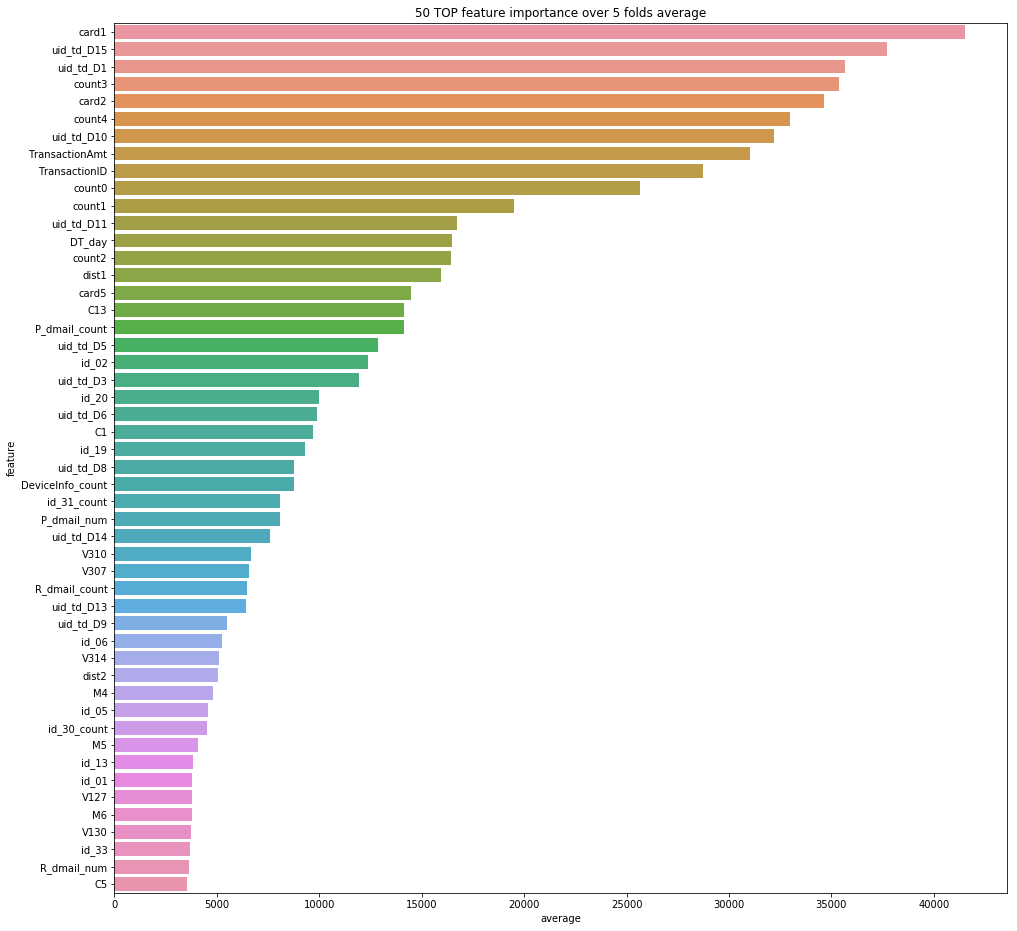

In [78]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));
# oh, forgot to remove transactionID. but we can see that transactionID is an important var even if it does noe make sense for our model,
# so maybe we should derive a var related to time, because transactionID gets larger as time going on.
# Or, we can do analysis to verify isfraud is related to time? sounds not resonable.

In [102]:
best_iter = clf.best_iteration
best_iter

3334

In [94]:
clf = lgb.LGBMClassifier(**params, num_boost_round=best_iter)
clf.fit(X_train.drop(["TransactionID"],axis=1), y)

LGBMClassifier(bagging_fraction=0.4181193142567742, bagging_seed=11,
        boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.3797454081646243,
        learning_rate=0.006883242363721497, max_depth=-1, metric='auc',
        min_child_samples=20, min_child_weight=0.03454472573214212,
        min_data_in_leaf=106, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_boost_round=3334, num_leaves=491,
        objective='binary', random_state=47, reg_alpha=0.3899927210061127,
        reg_lambda=0.6485237330340494, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1, verbose=-1)

In [96]:
X_train['isFraud_pred'] = clf.predict_proba(X_train.drop(["TransactionID"],axis=1))[:, 1]


In [97]:
X_train.head(5)

,V1,V3,V4,V6,V8,V11,V13,V14,V17,V20,...,uid_td_D13,uid_td_D14,uid_td_D15,DT_day,count0,count1,count2,count3,count4,isFraud_pred
0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,NaN,NaN,1001.0,1001.0,1.0,1.0,NaN,NaN,NaN,0.000017
1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,...,NaN,NaN,1001.0,1001.0,1.0,1.0,1.0,29.000000,29.0,0.000008
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,NaN,NaN,686.0,1001.0,4.0,4.0,4.0,73.500000,294.0,0.000009
3,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,...,NaN,NaN,890.0,1001.0,84.0,84.0,84.0,66.392857,5577.0,0.000004
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1001.0,1.0,1.0,1.0,50.000000,50.0,0.000010


In [98]:
# sub['isFraud'] = clf.predict_proba(X_test)[:, 1]
# sub.to_csv('ieee_fraud_sub_lightgbm.csv', index=False)

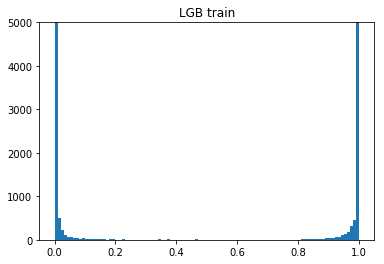

In [100]:
pred=X_train['isFraud_pred']
plt.hist(pred,bins=100)
plt.ylim((0,5000))
plt.title('LGB train')
plt.show()

In [101]:
# X_train["TransactionID"]
roc_auc_score(y,pred)

0.9999999185588117

# test AUC using random Forrest

In [109]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(X_train.drop(["TransactionID"],axis=1).fillna(-9999), y, test_size=0.25, random_state=0)

In [111]:
classifier = RandomForestClassifier(n_estimators=2000, random_state=0)
classifier.fit(rf_X_train, rf_y_train)


In [116]:
rf_X_train.shape

(442905, 216)

In [117]:
rf_X_test.shape

(147635, 216)

In [115]:
y_pred = classifier.predict(rf_X_test)
roc_auc_score(rf_y_test,y_pred)

0.9994910216859679

In [114]:
y_pred = classifier.predict(rf_X_train)
roc_auc_score(rf_y_train,y_pred)

1.0

# test AUC using Catboost

In [119]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=100, depth=5,cat_features=categorical_features_indices,learning_rate=0.5, loss_function='auc',
                            logging_level='Verbose')
model.fit(rf_X_train,rf_y_train,eval_set=(rf_X_test, rf_y_test),plot=True)

In [ ]:
fea_ = model.feature_importances_
fea_name = model.feature_names_
plt.figure(figsize=(10, 10))
plt.barh(fea_name,fea_,height =0.5)